Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

Data Dictionary

CustomerId: Unique ID which is assigned to each customer
Surname: Last name of the customer 
CreditScore: It defines the credit history of the customer.  
Geography: A customer’s location    
Gender: It defines the Gender of the customer   
Age: Age of the customer     
Tenure: Number of years for which the customer has been with the bank
NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
Balance: Account balance
HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
EstimatedSalary: Estimated salary 
isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
Excited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
0=No ( Customer did not leave the bank )
1=Yes ( Customer left the bank )

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.6.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import seaborn as sns
import keras
import tensorflow as tf

In [5]:
df= pd.read_csv("/bank.csv") 

In [6]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [14]:
# surname is not useful because it is just an identity, thus dropped 
df = df.drop("Surname", axis = 1)

In [16]:
# customer ID can be represented by the row number, which is already unique 
df = df.drop("CustomerId", axis = 1)

# EDA 

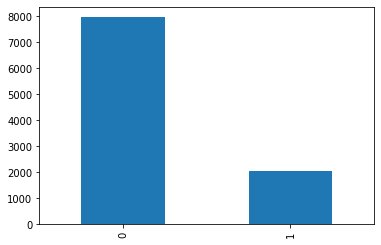

In [9]:
df.Exited.value_counts().plot.bar()

In [10]:
(df.Exited.value_counts())/(df.Exited.count())

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [12]:
print("*********Churned and Membership:************\n")
print("Total churned with membership")
print(df.IsActiveMember[df.Exited == 1].sum())

*********Churned and Membership:************

Total churned with membership
735


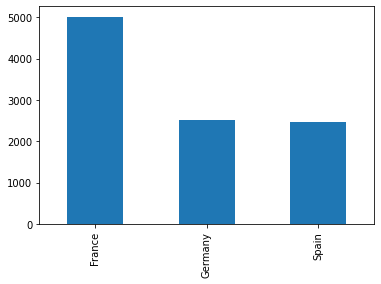

In [13]:
df.Geography.value_counts().plot.bar()

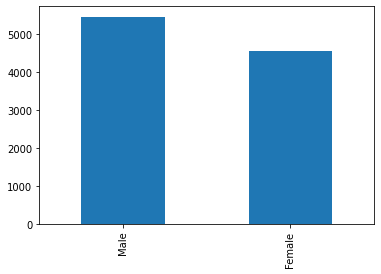

In [17]:
df.Gender.value_counts().plot.bar()

In [21]:
df = pd.get_dummies(df, columns=['Gender','Geography'])

In [53]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

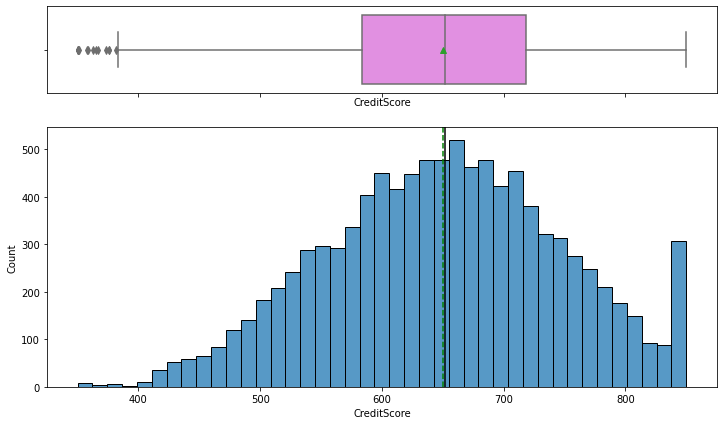

In [54]:
histogram_boxplot(df, "CreditScore")

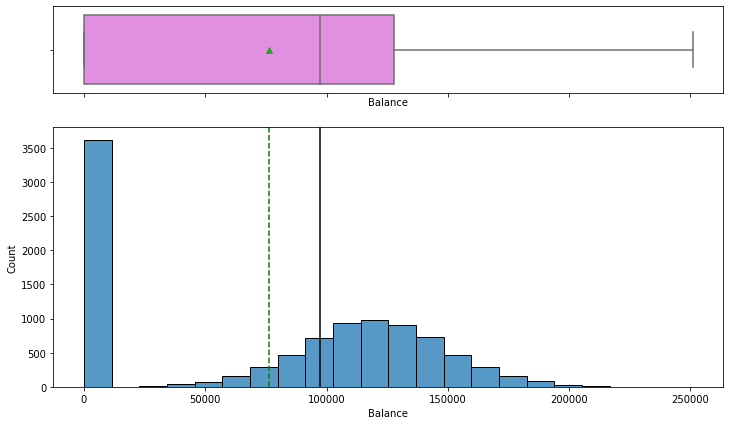

In [55]:
histogram_boxplot(df, "Balance")

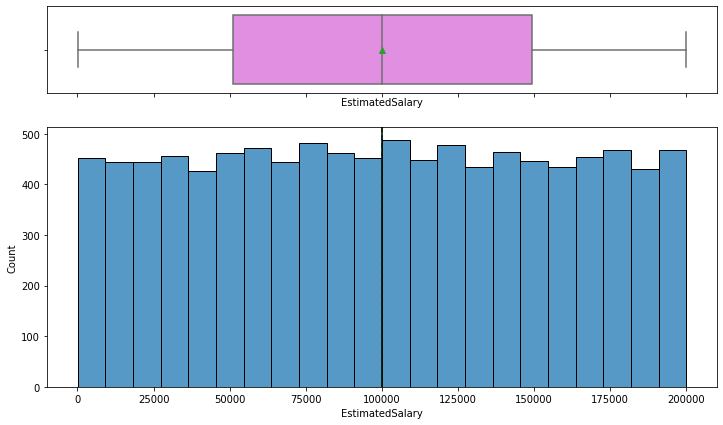

In [56]:
histogram_boxplot(df, "EstimatedSalary")

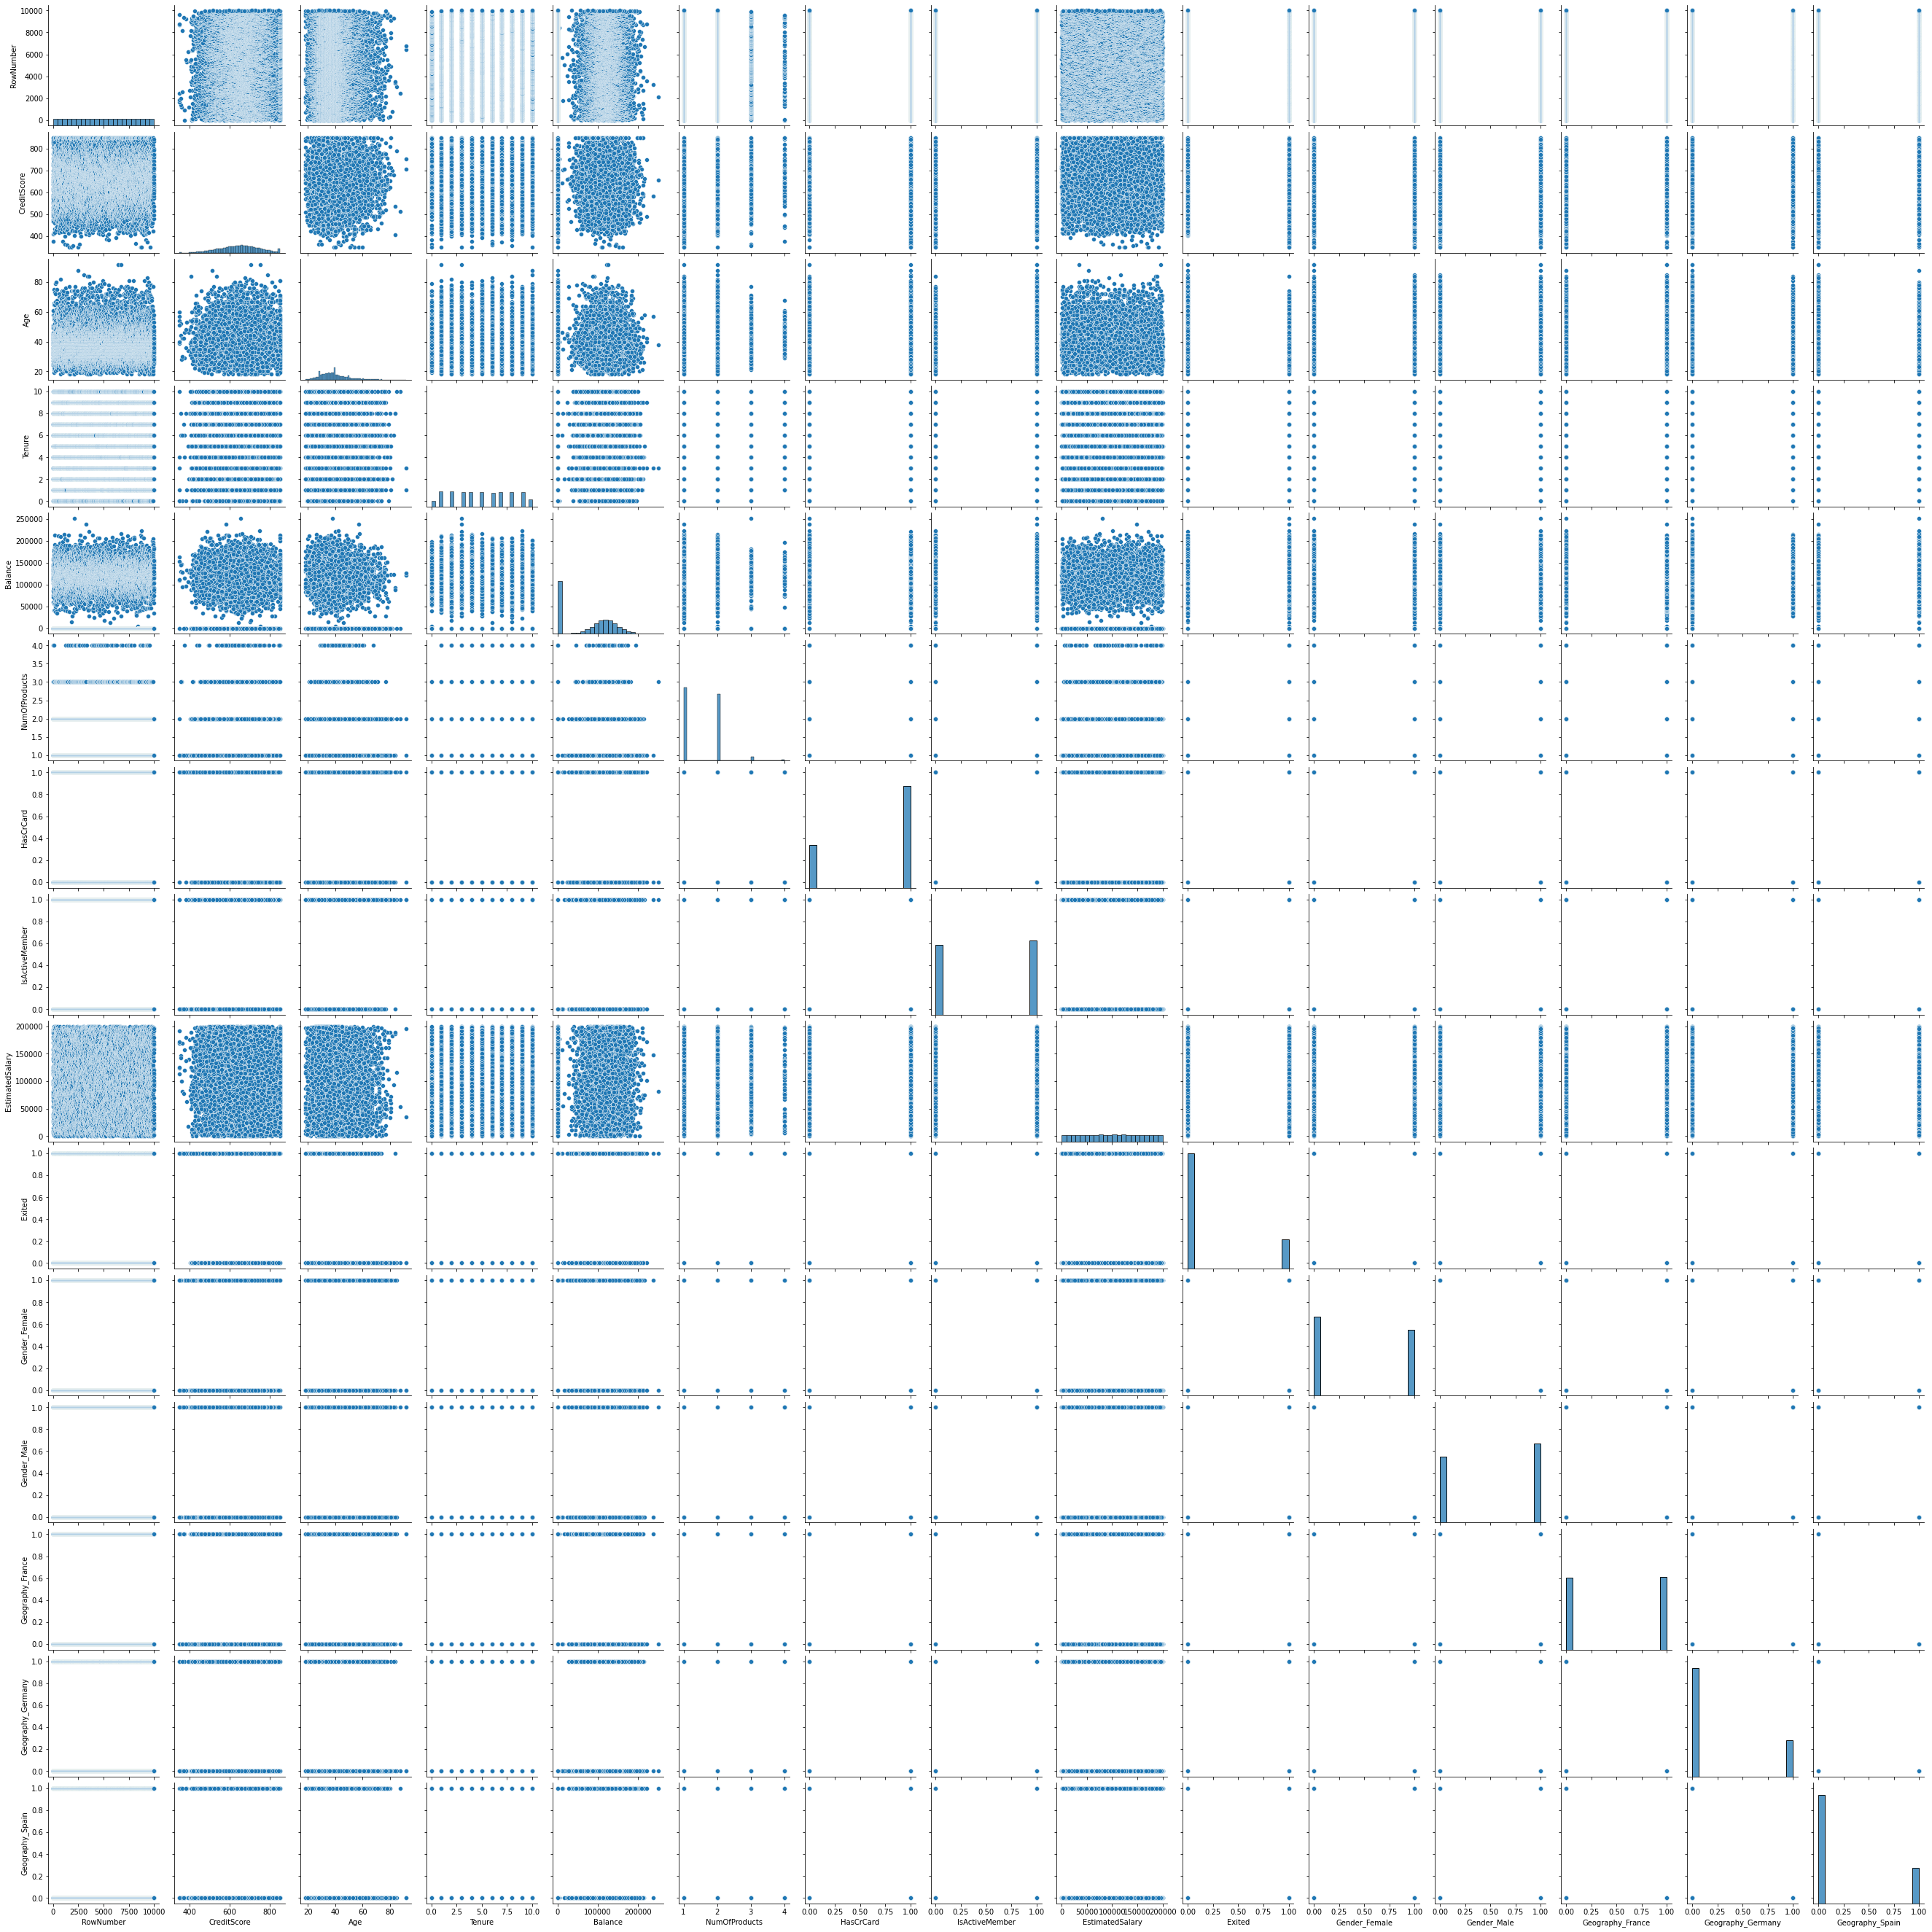

In [32]:
sns.pairplot(data=df)


In [23]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=df.iloc[:,1:15]

# Specify the target labels and flatten array
y= df.Exited


# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

y_train =  np.array(y_train)
y_test =  np.array(y_test)

In [24]:
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [25]:
# Using Tensorflow Keras instead of the original Keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


ncols = X_train.shape[0]

# Initialize the constructor
model = Sequential()

# Add an first hidden layer 
model.add(Dense(20, activation='relu', kernel_initializer='normal'))

# second hidden layer
#model.add(Dense(10, activation='relu', kernel_initializer='normal'))


# Add an output layer with one neuron and no activation specified
model.add(Dense(1))



In [26]:
optimizer = tf.keras.optimizers.Adam(0.01)


model.compile(loss='mean_squared_error',
              optimizer=optimizer , metrics = ['mae' , 'mse'])
                   

epochs = 50


In [27]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose = False)

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#print(hist)



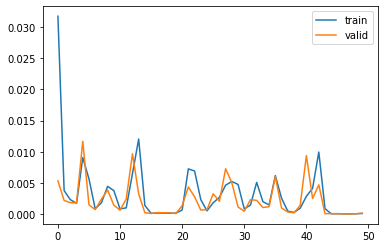

In [28]:
plt.plot(hist['mae'])
plt.plot(hist['val_mae'])
plt.legend(("train" , "valid") , loc =0)

In [29]:
loss = model.evaluate(X_test, y_test, verbose=False)

In [30]:
y_pred = np.round(model.predict(X_test))

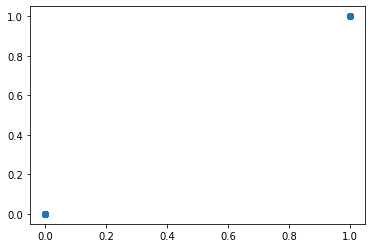

In [31]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
random_forest = RandomForestClassifier(n_estimators=100)

In [36]:
# Pandas Series.ravel() function returns the flattened underlying data as an ndarray.
random_forest.fit(X_train,y_train.ravel())   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
y_pred = random_forest.predict(X_test)

In [38]:
random_forest.score(X_test,y_test)

1.0

In [39]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a churn is not churn and not churning as a churn 

### Which case is more important? 
* Predicting that churn is not chuen but it is a churn. It will lose opportunity to salvage an existing client. 

### How to reduce this loss i.e need to reduce False Negative?
* Bank  would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the Company can identify potential churn.

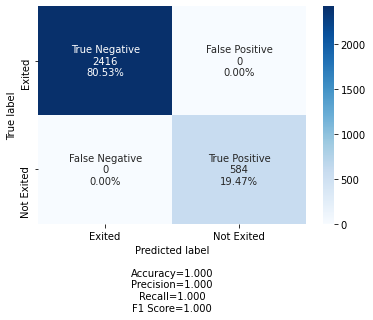

In [40]:
cm1=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Exited','Not Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [41]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model.add(Dense(units=16, input_dim = 29,activation='relu'))   # input of 29 columns as shown above
# hidden layer
model.add(Dense(units=24,activation='relu'))
#Adding Dropout to prevent overfitting 
model.add(Dropout(0.5))
model.add(Dense(24,activation='relu'))
model.add(Dense(24,activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (fraud or not)
# We use the sigmoid because we want probability outcomes
model.add(Dense(1,activation='sigmoid'))                        # binary classification fraudulent or not

In [42]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                6

In [44]:
#fitting the model
history=model.fit(X_train,y_train,batch_size=15,epochs=10,validation_split=0.2)

Epoch 1/10
374/374 [==============================] - 2s 3ms/step - loss: 0.1623 - accuracy: 0.9693 - val_loss: 2.2581e-04 - val_accuracy: 1.0000
Epoch 2/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 1.5798e-05 - val_accuracy: 1.0000
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 5.1666e-07 - val_accuracy: 1.0000
Epoch 4/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 6.9231e-08 - val_accuracy: 1.0000
Epoch 5/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 1.7713e-08 - val_accuracy: 1.0000
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 2.2297e-08 - val_accuracy: 1.0000
Epoch 7/10
374/374 [==============================] - 1s 2ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 7.4197e-08 -

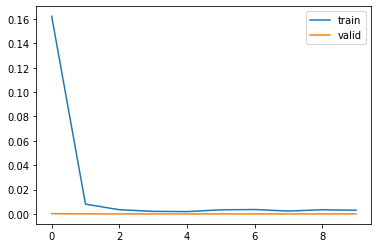

In [45]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

In [46]:
score = model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 1ms/step - loss: 5.2087e-12 - accuracy: 1.0000


In [47]:
print(score)

[5.2087115003096596e-12, 1.0]


**Conclusion:** 

Recall is increased but the precision is very bad.  There is still  lot of scope of  improvements  as follows:

1) Threshold can be tuned to get the optimal value 

2) Resampling techniques can be applied to balanced the data and then train the model 

3) Hyperparameter tuning can be applied to tune the different Hyperparameters


We can select the Model-1 as our final model based on the above analysis 